## Exploratory Data Analysis on New York Yellow Taxi Trip Data

### Table of Contents
- [0. Set-up](#su)
- [1. Describe Dataset](#dd)
- [2. Load Dataset](#ld)
- [3. Explore and Wrangle Dataset](#ewd)
- [4. Research Question](#rq)
- [5. Data Analysis & Visualizations](#dav)
- [6. Conclusions](#c)

### 0. Set-up <a name="su"></a>

In [185]:
# load libraries
options(tidyverse.quiet = TRUE) 

# basics
library(MASS)
library(tidyverse)
library(dplyr)
library(broom)
library(repr)
library(modelr)

# plots
library(ggplot2)
library(gridExtra)
library(ggridges)
library(GGally)
theme_set(theme_light())

# dates
library(lubridate)

### 1. Describe Dataset <a name="dd"></a>

We found this dataset on New York city [open data](https://data.world/new-york-city/yellow-tripdata-february-2017/workspace/file?filename=yellow_tripdata_2017-02.csv). This data contains every yellow taxi trip in New York city in February 2017. The original downloaded file has more than 9 million rows so we will randomly sample 1 million rows.

### 2. Load Dataset <a name="ld"></a>

In [8]:
# read-in data
taxi_smaller <- suppressMessages(read_csv("../data/taxi_smaller.csv"))

# confirm dataset has been read in
head(taxi_smaller)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,2017-02-08 15:52:19,2017-02-08 15:57:21,5,0.99,1,N,163,230,1,5.5,0.0,0.5,1.89,0,0.3,8.19
2,2017-02-06 12:28:29,2017-02-06 12:32:23,2,0.76,1,N,237,236,1,5.0,0.0,0.5,1.45,0,0.3,7.25
2,2017-02-28 07:57:50,2017-02-28 08:06:32,5,1.18,1,N,140,162,1,7.5,0.0,0.5,1.66,0,0.3,9.96
2,2017-02-26 02:36:29,2017-02-26 02:50:51,1,5.32,1,N,164,166,1,16.5,0.5,0.5,1.00,0,0.3,18.80
2,2017-02-25 21:50:27,2017-02-25 21:55:25,1,1.04,1,N,236,237,1,5.5,0.5,0.5,1.36,0,0.3,8.16
1,2017-02-25 00:41:23,2017-02-25 01:03:15,1,3.50,1,N,148,181,1,16.0,0.5,0.5,1.50,0,0.3,18.80


### 3. Explore and Wrangle Dataset <a name="ewd"></a>

In [16]:
# get column names
print(names(taxi_smaller))

 [1] "VendorID"              "tpep_pickup_datetime"  "tpep_dropoff_datetime"
 [4] "passenger_count"       "trip_distance"         "RatecodeID"           
 [7] "store_and_fwd_flag"    "PULocationID"          "DOLocationID"         
[10] "payment_type"          "fare_amount"           "extra"                
[13] "mta_tax"               "tip_amount"            "tolls_amount"         
[16] "improvement_surcharge" "total_amount"         


**Some interesting columns we could look at in more details**
- `tpep_pickup_datetime`: The date and time when the meter was engaged
- `tpep_dropoff_datetime`: The date and time when the meter was disengaged
- `passenger_count`: The number of passengers in the trip
- `trip_distance`: The trip distance in miles reported by the taximeter
- `RatecodeID`: The final rate code at the end of the trip
- `PULocationID`: TLC Taxi Zone in which the taximeter was engaged initially
- `DOLocationID`: TLC Taxi Zone in which the taximeter was engaged in the end
- `payment_type`: How the passenger paid for the trip (numerically encoded, 1 - credit card, 2 - cash, 3~6 - others)
- `tip_amount`: This field is automatically generated for credit card tips (cash tips not included)
- `total_amount`: The total amount charged to passengers (cash tips not included)

In [174]:
# wrangling 1: only include payment_type == 1, credit card transactions
# wrangling 2: select useful columns
# wrangling 3: use tip_percentage instead of tip_amount
taxi <- taxi_smaller %>% 
  filter(payment_type == 1) %>% 
  select(tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count,
         RatecodeID, trip_distance, PULocationID, DOLocationID, tip_amount, total_amount) %>%
  mutate(tip_pct = tip_amount / total_amount)

**Descriptive Statistics**

In [175]:
summary(taxi)

 tpep_pickup_datetime          tpep_dropoff_datetime         passenger_count
 Min.   :2017-02-01 00:00:23   Min.   :2017-01-24 15:39:43   Min.   :0.000  
 1st Qu.:2017-02-07 19:14:14   1st Qu.:2017-02-07 19:27:41   1st Qu.:1.000  
 Median :2017-02-14 21:03:44   Median :2017-02-14 21:18:24   Median :1.000  
 Mean   :2017-02-14 22:02:17   Mean   :2017-02-14 22:17:42   Mean   :1.615  
 3rd Qu.:2017-02-22 00:50:58   3rd Qu.:2017-02-22 01:06:58   3rd Qu.:2.000  
 Max.   :2017-02-28 23:59:59   Max.   :2017-03-01 23:20:37   Max.   :9.000  
                                                                            
   RatecodeID     trip_distance      PULocationID    DOLocationID  
 Min.   : 1.000   Min.   :  0.000   Min.   :  1.0   Min.   :  1.0  
 1st Qu.: 1.000   1st Qu.:  1.000   1st Qu.:114.0   1st Qu.:107.0  
 Median : 1.000   Median :  1.700   Median :162.0   Median :162.0  
 Mean   : 1.042   Mean   :  2.943   Mean   :163.8   Mean   :161.2  
 3rd Qu.: 1.000   3rd Qu.:  3.100   3rd Qu.:

In [176]:
print(paste("Number of rows: ", nrow(taxi), ", Number of columns: ", ncol(taxi), sep=""))

[1] "Number of rows: 1000000, Number of columns: 10"


**Observations:**
- Possibly some missing values in `RatecodeID` encoded as 99
- Missing values in `tip_pct` for rows with a `total_amount` of 0 (remove these)
- `datetime` values need to be grouped to: time of a day and day in a week, for inferential analysis
- Check for possible outliers in `trip_distance`, `tip_amount`, and `total_amount`

In [177]:
# wrangling 4: remove 102 NA's
taxi <- taxi %>% filter(!is.na(tip_pct))

# quick check for missing value
nrow(taxi[rowSums(is.na(taxi))==0,]) == nrow(taxi)

[1] TRUE

**Group Datatime Objects**

In [283]:
# wrangling 5: group datetime objects
taxi <- taxi %>% 
  mutate(pu_hour = hour(tpep_pickup_datetime),
         pu_wday = wday(tpep_pickup_datetime, label = TRUE, abbr = FALSE)) %>%
  mutate(pu_time_of_day_group = case_when(pu_hour >= 22 | pu_hour < 5   ~ "middle_night",
                                      (pu_hour >= 5 & pu_hour < 12)  ~ "morning",
                                      (pu_hour >= 12 & pu_hour < 18) ~ "afternoon",
                                      (pu_hour >= 18 & pu_hour <= 21  ) ~ "evening"),
         pu_wday_group = if_else((pu_wday == 'Saturday' | pu_wday == 'Sunday'), "weekend", "weekday"))

# take a look at counts in each group to see if events are approximately evenly distributed
taxi %>% 
  group_by(pu_time_of_day_group) %>%
  summarise(count_event = n())

pu_time_of_day_group,count_event
<chr>,<int>
afternoon,292905
evening,249054
middle_night,204798
morning,253141


### 4. Research Question <a name="rq"></a>

**Inferential:**  
Whether tip generosity is dependent on the time of the day/day of the week?

**Visualization and Statistical Inference guidelines:**
- Is there a trend in every hour of a day with tip percentage?
- Are grouped times of a day significantly different from each other?
- Is there an effect on tip percentage given the day of a week?
- How is tip percentage distributed in each segments (time of a day/day of a week)?

### 5. Data Analysis & Visualizations <a name="dav"></a>

**Time of a Day Analysis**

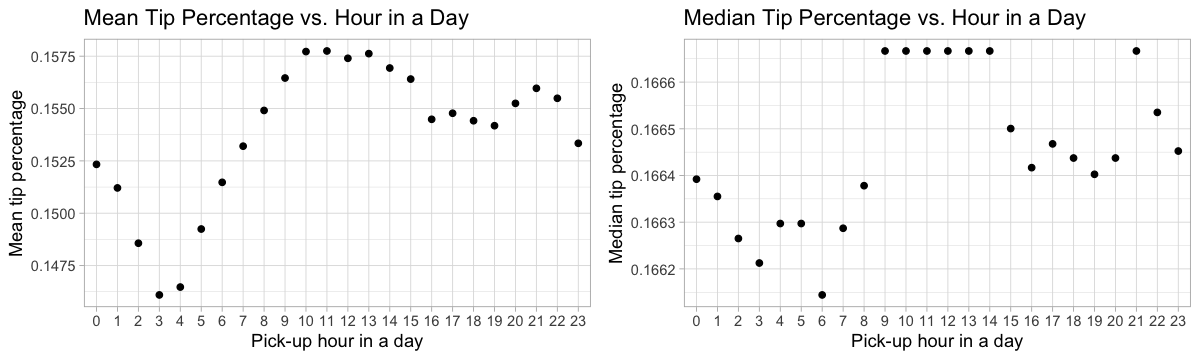

In [257]:
options(repr.plot.width = 10, repr.plot.height = 3)

hour_summary_stats <- taxi %>%
  group_by(pu_hour) %>%
  summarise(pu_hour_mean = mean(tip_pct),
            pu_hour_median = median(tip_pct))

# plot hour vs. mean
tod1 <- summary_stats %>%
  ggplot(aes(factor(pu_hour), pu_hour_mean)) +
    geom_point() +
    labs(x = "Pick-up hour in a day", y = "Mean tip percentage", title = "Mean Tip Percentage vs. Hour in a Day")

# plot hour vs. median
tod2 <- summary_stats %>%
  ggplot(aes(factor(pu_hour), pu_hour_median)) +
    geom_point() +
    labs(x = "Pick-up hour in a day", y = "Median tip percentage", title = "Median Tip Percentage vs. Hour in a Day")

grid.arrange(tod1, tod2, ncol = 2)

**Day of a Week Analysis**

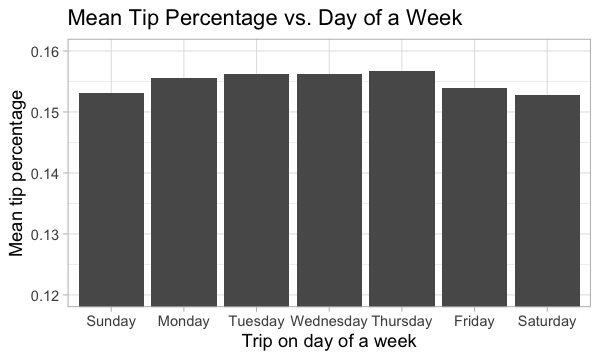

In [220]:
options(repr.plot.width = 5, repr.plot.height = 3)

taxi %>%
  group_by(pu_wday) %>%
  summarise(pu_wday_mean = mean(tip_pct)) %>%
  ggplot(aes(factor(pu_wday), pu_wday_mean)) +
    geom_bar(stat = 'identity') +
    coord_cartesian(ylim = c(0.12, 0.16)) +
    labs(x = "Trip on day of a week", y = "Mean tip percentage", title = "Mean Tip Percentage vs. Day of a Week")

**Grouped Analysis for Time of a Day**

In [263]:
tod_gp_sample_stats <- taxi %>%
  group_by(pu_time_of_day_group) %>%
  summarise(tip_mean = mean(tip_pct))

tod_gp_sample_stats

pu_time_of_day_group,tip_mean
<chr>,<dbl>
afternoon,0.1562388
evening,0.1549165
middle_night,0.1523230
morning,0.1554275


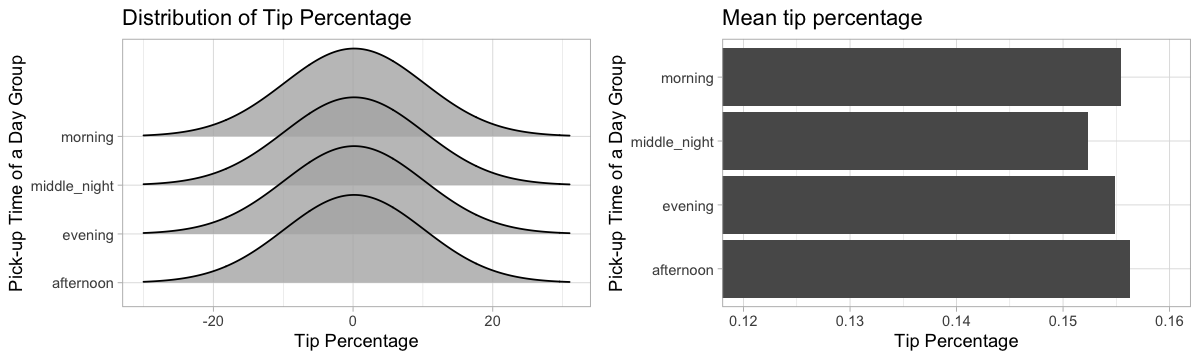

In [264]:
options(repr.plot.width = 10, repr.plot.height = 3)

time_dist <- taxi %>%
  ggplot(aes(tip_pct, pu_time_of_day_group)) +
  geom_density_ridges(alpha = 0.8, bandwidth = 10) +
  scale_y_discrete(expand = expand_scale(add = c(0.5, 2))) +
  labs(x = "Tip Percentage", y = "Pick-up Time of a Day Group", title = "Distribution of Tip Percentage")

time_group <- tod_gp_sample_stats %>%
  ggplot(aes(factor(pu_time_of_day_group), tip_mean)) +
    geom_bar(stat = 'identity') +
    coord_flip(ylim = c(0.12, 0.16)) +
    labs(y = "Tip Percentage", x = "Pick-up Time of a Day Group", title = "Mean tip percentage")

grid.arrange(time_dist, time_group, ncol = 2)

**Difference between Weekdays and Weekends**

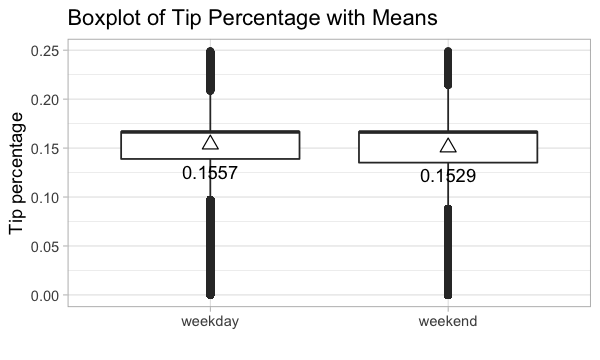

In [259]:
options(repr.plot.width = 5, repr.plot.height = 3)
wkday_gp_sample_stat <- taxi %>% 
  group_by(pu_wday_group) %>% 
  summarise(mean_tip = mean(tip_pct))

taxi %>%
  filter(tip_pct <= 0.25 & tip_pct >= 0) %>%
  ggplot(aes(factor(pu_wday_group), tip_pct)) +
    geom_boxplot() +
    stat_summary(fun.y = "mean", geom = "point", shape = 2, size=3) +
    geom_text(data = wkday_gp_sample_stat, aes(label = round(mean_tip, 4), x = as.factor(pu_wday_group), y = mean_tip-0.03)) +
    labs(x = "", y = "Tip percentage", title = "Boxplot of Tip Percentage with Means")

In [276]:
# Sample test for significance
# times of a day groups
glance(lm(tip_pct ~ pu_time_of_day_group, data = taxi))

# cross weekday group and time of day group
#glance(lm(tip_pct ~ pu_time_of_day_group * pu_wday_group, data = taxi))

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0.0006992181,0.0006962199,0.05286847,233.2111,2.848053e-151,4,1520856,-3041703,-3041644,2794.779,999894


In [250]:
# other plausible graphs/observations?

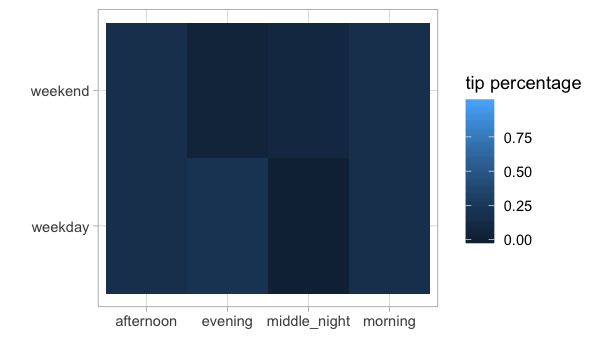

In [277]:
options(repr.plot.width = 5, repr.plot.height = 3)

# Heatmap of weekday group x time of day group on tip percentage
taxi %>% ggplot(aes(pu_time_of_day_group, pu_wday_group, fill=tip_pct)) + geom_tile() +
  labs(x = "", y = "", fill = "Tip percentage")

### 6. Conclusions <a name="c"></a>

- By plotting mean tip percentage on every hour of a day, we found that mean tip percentage from 10am to 2pm on a day is higher than other times of a day
- By grouping times of a day into groups: middle_night (10pm - 4am), morning (5am - 11pm), afternoon (12pm - 5pm), evening (6pm - 9pm), we have approximately evenly distributed event counts and from a simple test we can see that mean tip percentages from these groups are different.

Next steps:
- Conduct more formal tests on differences in mean tip percentage from morning vs evening ...
- Should we take into account effect of passenger count and trip distance?
- Weekdays event count is about 3 times weekend counts, will this be a data imbalance problem?